In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sunpy 
import sunpy.map
from sunpy.coordinates import (Helioprojective, propagate_with_solar_surface,
                               )
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import eispac
from astropy.visualization import ImageNormalize, AsinhStretch
from aiapy.calibrate import normalize_exposure, register, update_pointing
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy import constants as const
from sun_blinker import SunBlinker


In [2]:
eis_pointing_save = np.load('../../src/EIS/eis_pointing/eis_20221020_234355/pointing_verification/20221020_234355/offsets.npz',allow_pickle=True)

In [3]:
eis_pointing_x = eis_pointing_save['x']
eis_pointing_y = eis_pointing_save['y']

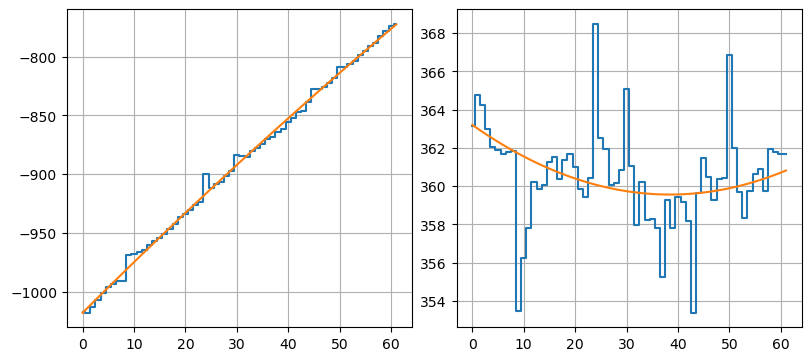

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3.5),layout='constrained')
ax1.step(np.arange(62),eis_pointing_x[380,:],where='mid')
ax2.step(np.arange(62),eis_pointing_y[380,:],where='mid')
fit_x = np.polyfit(np.arange(62),eis_pointing_x[380,:],2)
fit_y = np.polyfit(np.arange(62)[np.r_[0:10,13:49,53:62]],eis_pointing_y[380,np.r_[0:10,13:49,53:62]],2)
ax1.plot(np.arange(62),np.polyval(fit_x,np.arange(62)))
ax2.plot(np.arange(62),np.polyval(fit_y,np.arange(62)))


for ax_ in (ax1,ax2):
    ax_.grid(True)


In [5]:
eis_pointing_x_fix = np.zeros_like(eis_pointing_x)
eis_pointing_y_fix = np.zeros_like(eis_pointing_y)

good_x_pos = np.r_[0:62]
for ii in range(512):
    fix_x_ = np.polyfit(good_x_pos,eis_pointing_x[ii,good_x_pos],2)
    fix_y_ = np.polyfit(good_x_pos,eis_pointing_y[ii,good_x_pos],2)

    eis_pointing_x_fix[ii,:] = np.polyval(fix_x_,np.arange(62))
    eis_pointing_y_fix[ii,:] = np.polyval(fix_y_,np.arange(62))

In [6]:
y_interp = np.linspace(eis_pointing_y_fix.min(), eis_pointing_y_fix.max(), eis_pointing_y_fix.shape[0])
x_interp = np.linspace(eis_pointing_x_fix.min(), eis_pointing_x_fix.max(), eis_pointing_x_fix.shape[1])

In [7]:
eis_195_fitres = eispac.read_fit("../../src/EIS/DHB_007_v2/20221020T2343/eis_20221020_234355.fe_12_195_119.1c-0.fit.h5")
eis_195_intmap = eis_195_fitres.get_map()

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221020_234355.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


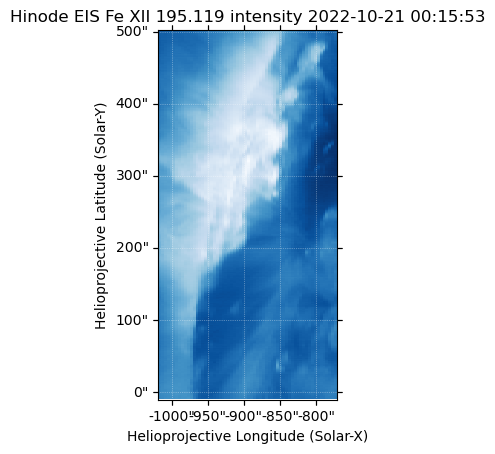

In [8]:
eis_195_intmap.plot()

In [9]:
eis_195_intmap.data.shape

(512, 62)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(<matplotlib.patches.Circle at 0x7fe3aa3c4ec0>, None)

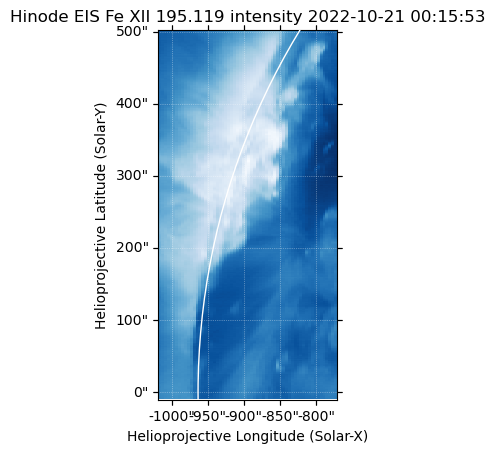

In [10]:
eis_crop_bottom_left = [0,0]
eis_crop_top_right = [62,512]
eis_195_intmap_crop = eis_195_intmap.submap(eis_crop_bottom_left*u.pix,
                                           top_right=[eis_crop_top_right[0]-1,
                                                     eis_crop_top_right[1]-1]*u.pix)
# eis_195_intmap_crop = eis_195_intmap
eis_195_intmap_crop.plot()
eis_195_intmap_crop.draw_limb()

In [11]:
eis_195_intmap_crop.data.shape

(512, 62)

In [12]:
eis_pointing_x_crop = eis_pointing_x_fix[eis_crop_bottom_left[1]:eis_crop_top_right[1],
                                     eis_crop_bottom_left[0]:eis_crop_top_right[1]]
eis_pointing_y_crop = eis_pointing_y_fix[eis_crop_bottom_left[1]:eis_crop_top_right[1],
                                     eis_crop_bottom_left[0]:eis_crop_top_right[1]]

In [13]:
def xy_to_wcs(x,y,data,date_obs,instrument,observatory):
    nx = data.shape[1]
    ny = data.shape[0]
    wcs_header = sunpy.map.make_fitswcs_header(data,
                                               coordinate=SkyCoord(x[nx//2], y[ny//2], unit=u.arcsec,
                                                                             frame="helioprojective", obstime=date_obs,
                                                                             rsun=696000000.0*u.m),
                                                reference_pixel=[nx//2, ny//2]*u.pix,
                                            scale=[np.abs(x[-1] - x[0])/(nx - 1), np.abs(y[-1] - y[0])/(ny - 1)] * u.arcsec/u.pix,
                                            instrument=instrument,
                                            observatory=observatory,
                                            ) 
    return WCS(wcs_header)                                                  
    

In [14]:
def solar_rotation_compensate_xy_interp(x, y, date_start, date_end, date_average):
    nx = x.shape[1]
    ny = y.shape[0]

    x_derot = np.zeros_like(x)
    y_derot = np.zeros_like(y)

    # EIS scans from west to east
    date_grid = np.linspace(date_end, date_start, nx)

    unify_helioprojective_frame = Helioprojective(observer='earth', obstime=date_average,rsun=696000000.0*u.m)


    for ii in range(nx):
        helioprojective_frame_ii = Helioprojective(observer='earth', obstime=date_grid[ii],rsun=696000000.0*u.m)
        coords_ii = SkyCoord(x[:,ii]*u.arcsec, y[:,ii]*u.arcsec, frame=helioprojective_frame_ii)
        with Helioprojective.assume_spherical_screen(eis_195_intmap_crop.observer_coordinate,only_off_disk=True):
            with propagate_with_solar_surface(rotation_model='rigid'):
                coords_ii_unified = coords_ii.transform_to(unify_helioprojective_frame)
        x_derot[:,ii] = coords_ii_unified.Tx.to_value(u.arcsec)
        y_derot[:,ii] = coords_ii_unified.Ty.to_value(u.arcsec)
    
    x_interp = np.linspace(x_derot.min(), x_derot.max(), nx)
    y_interp = np.linspace(y_derot.min(), y_derot.max(), ny)

    return x_derot, y_derot, x_interp, y_interp    

In [15]:
eis_pointing_x_derot, eis_pointing_y_derot, x_interp_derot, y_interp_derot = \
    solar_rotation_compensate_xy_interp(eis_pointing_x_crop, eis_pointing_y_crop, eis_195_intmap_crop.date_start, eis_195_intmap_crop.date_end, eis_195_intmap_crop.date_average)

In [16]:
xi_interp_derot = np.moveaxis(np.array(np.meshgrid(x_interp_derot, y_interp_derot)), 0, -1)
points_derot = (eis_pointing_x_derot.flatten(), eis_pointing_y_derot.flatten())

In [17]:
eis_int_interp_linear_func_derot = LinearNDInterpolator(points_derot, eis_195_intmap_crop.data.flatten())
eis_int_interp_linear_derot = eis_int_interp_linear_func_derot(xi_interp_derot)

In [18]:
eis_interp_wcs_derot = xy_to_wcs(x_interp_derot, y_interp_derot, eis_int_interp_linear_derot, eis_195_intmap_crop.date_average, 'EIS', 'Hinode')

In [19]:
eis_195_int_interp_linear_map_derot = sunpy.map.Map(eis_int_interp_linear_derot, eis_interp_wcs_derot)
eis_195_int_interp_linear_map_derot.plot_settings["aspect"] = eis_195_int_interp_linear_map_derot.scale.axis2/eis_195_int_interp_linear_map_derot.scale.axis1
eis_195_int_interp_linear_map_derot.plot_settings["norm"] = ImageNormalize(stretch=AsinhStretch())
eis_195_int_interp_linear_map_derot.plot_settings["cmap"] = 'sdoaia193'


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


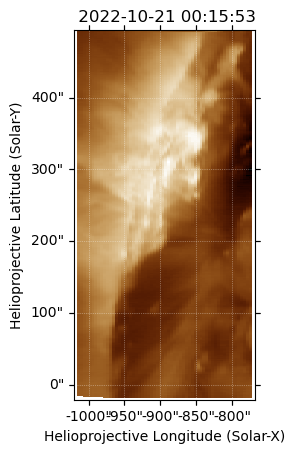

In [20]:
eis_195_int_interp_linear_map_derot.plot()

In [21]:
eis_195_velmap = eis_195_fitres.get_map(measurement='velocity')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


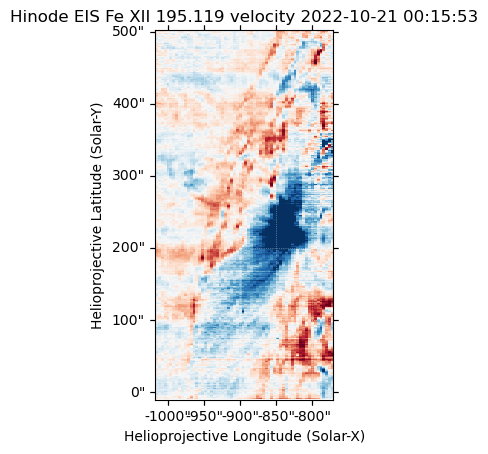

In [22]:
eis_195_velmap.plot()

In [23]:
eis_195_velmap_crop = eis_195_velmap.submap(eis_crop_bottom_left*u.pix,
                                           top_right=[eis_crop_top_right[0]-1,
                                                     eis_crop_top_right[1]-1]*u.pix)

In [24]:
eis_195_vel_interp_linear_func_derot = LinearNDInterpolator(points_derot, eis_195_velmap_crop.data.flatten())
eis_195_vel_interp_linear_derot = eis_195_vel_interp_linear_func_derot(xi_interp_derot)

In [25]:
eis_195_vel_interp_linear_map_derot = sunpy.map.Map(eis_195_vel_interp_linear_derot, eis_interp_wcs_derot)
eis_195_vel_interp_linear_map_derot.plot_settings["aspect"] = eis_195_vel_interp_linear_map_derot.scale.axis2/eis_195_vel_interp_linear_map_derot.scale.axis1
eis_195_vel_interp_linear_map_derot.plot_settings["norm"] = ImageNormalize(vmin=-15,vmax=15)
eis_195_vel_interp_linear_map_derot.plot_settings["cmap"] = 'RdBu_r'

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


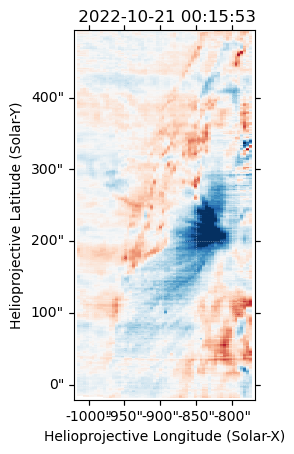

In [26]:
eis_195_vel_interp_linear_map_derot.plot()

In [27]:
eis_195_widmap = eis_195_fitres.get_map(measurement='width')

eis_195_true_width = np.sqrt( (eis_195_widmap.data * np.sqrt(8*np.log(2)))**2 - (eis_195_fitres.meta["slit_width"][:,np.newaxis])**2)
eis_195_true_width = eis_195_true_width[eis_crop_bottom_left[1]:eis_crop_top_right[1],
                                     eis_crop_bottom_left[0]:eis_crop_top_right[1]]
eis_195_v1oe = eis_195_true_width*u.angstrom/np.sqrt(4*np.log(2))*const.c/(195.119*u.angstrom)
vth2 = 2*const.k_B*(10**6.2)*u.K/const.u/55.85
vnth = np.sqrt(eis_195_v1oe**2 - vth2).to(u.km/u.s)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/tmp/ipykernel_118416/1379525631.py:3: RuntimeWarning: invalid value encountered in sqrt
  eis_195_true_width = np.sqrt( (eis_195_widmap.data * np.sqrt(8*np.log(2)))**2 - (eis_195_fitres.meta["slit_width"][:,np.newaxis])**2)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [28]:
eis_195_wid_interp_linear_func_derot = LinearNDInterpolator(points_derot, vnth.flatten())
eis_195_wid_interp_linear_derot = eis_195_wid_interp_linear_func_derot(xi_interp_derot)

In [29]:
eis_195_wid_interp_linear_derot_map = sunpy.map.Map(eis_195_wid_interp_linear_derot, eis_interp_wcs_derot)

eis_195_wid_interp_linear_derot_map.plot_settings["aspect"] = eis_195_wid_interp_linear_derot_map.scale.axis2/eis_195_wid_interp_linear_derot_map.scale.axis1
eis_195_wid_interp_linear_derot_map.plot_settings["norm"] = ImageNormalize(vmin=10,vmax=40)
eis_195_wid_interp_linear_derot_map.plot_settings["cmap"] = 'magma'

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


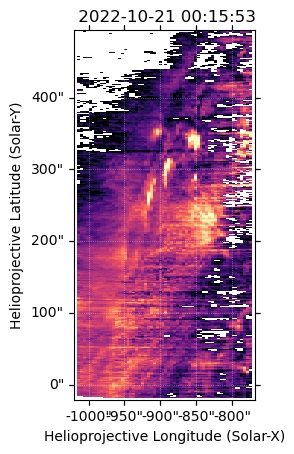

In [30]:
eis_195_wid_interp_linear_derot_map.plot()

In [31]:
eis_195_int_interp_linear_map_derot.save("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_intmap_shift.fits",overwrite=True)
eis_195_vel_interp_linear_map_derot.save("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits",overwrite=True)
eis_195_wid_interp_linear_derot_map.save("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_widmap_shift.fits",overwrite=True)